#Yelp NLP

##Phase I - Pre-processing the data:

###Objectives in this phase:
The main objective of this phase is **exploratory data analysis**. We do it by analysing each attribute and,
1. Look at the distribution (in case of numerical attribute)
2. Standardize the data (in case of numerical attribute)
3. Convert categorical data to numerical data
4. Identify the output variable(s)
5. Feature Engineering (removing redundant data features, finding dependent features)
    - PCA - finding independent and uncorrelated features that have significant variance
    - summarizing or clustering data with not much variance
6. Visualizing the data
    - histograms
    - scatter plot of output vs each attribute
7. Identify the features among the attributes

###Splitting the dataset into small chunks:
First, we split the large dataset into small chunks as separate files. Primarily, user.json and review.json are huge files that requires a lot of RAM. Splitting the files enables us to load one fold at a time, thereby, reducing the load on memory.

In [19]:
import sys
import os

#setting up path to dataset
user_json = os.path.join("..","data","user.json")
user_data_dir = os.path.join("..","data","user")
review_json = os.path.join("..","data","review.json")
review_data_dir = os.path.join("..","data","review")

In [6]:
import csv
import json

def convert_review_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['user_id','business_id','text','stars','useful','funny','cool']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    for line in json_file:
        count += 1
        j = json.loads(line)
        j['text'] = j['text'].replace("\n"," ")
        csv_arr = list()
        for column in columns:
            if column in j:
                csv_arr.append(j[column])
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    json_file.close()
    
print("Converting review json to chunks of csv files...")
review_json = os.path.join("..","data","review.json")
review_csv_dir = os.path.join("..","data","review_csv")
convert_review_to_csv(json_file_path=review_json, out_dir=review_csv_dir, lines_per_file=50000)
print("Done")

Converting review json to chunks of csv files...
Done


In [7]:
import csv
import json

def convert_user_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 
               'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 
               'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 
               'compliment_funny', 'compliment_writer', 'compliment_photos']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    for line in json_file:
        count += 1
        j = json.loads(line)
        csv_arr = list()
        for column in columns:
            if column in j:
                csv_arr.append(j[column])
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    json_file.close()
    
print("Converting user json to chunks of csv files...")
user_json = os.path.join("..","data","user.json")
user_csv_dir = os.path.join("..","data","user_csv")
convert_user_to_csv(json_file_path=user_json, out_dir=user_csv_dir, lines_per_file=50000)
print("Done")

Converting user json to chunks of csv files...
Done


In [25]:
import csv
import os
import json

def convert_business_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['business_id','name','neighborhood','address','city','state','postal_code','latitude','longitude','stars','categories']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    business = list()
    for line in json_file:
        count += 1
        j = json.loads(line)
        business.append(j['business_id'])
        csv_arr = list()
        for column in columns:
            column_hierarchy = column.split(".")
            json_obj = j
            is_there = True
            for c in column_hierarchy:
                if c in json_obj:
                    json_obj = json_obj[c]
                else:
                    is_there = False
                    break
            if is_there:
                if isinstance(json_obj,list):
                    categories = ""
                    for obj in json_obj:
                        categories += ", "+obj;
                    csv_arr.append(categories[2:])
                else:
                    csv_arr.append(json_obj)
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
            output.writerow(columns)
    json_file.close()
    
    output = csv.writer(open(os.path.join(out_dir,"business_id.csv"), "w+"))
    for b in range(len(business)):
        output.writerow([str(business[b]), b])

    
print("Converting business json to chunks of csv files...")
biz_json = os.path.join("..","data","business.json")
biz_csv_dir = os.path.join("..","data","biz_csv")
convert_business_to_csv(json_file_path=biz_json, out_dir=biz_csv_dir, lines_per_file=50000)
print("Done")

Converting business json to chunks of csv files...
Done


In [35]:
import os
import json
import csv

def check_in_pre_processing(file_path, out_dir):
    check_in_file = open(file_path,"r")
    day_map = {
        "Sunday" : 1,
        "Monday" : 2,
        "Tuesday" : 3,
        "Wednesday" : 4,
        "Thursday" : 5,
        "Friday" : 6,
        "Saturday" : 7
    }
    time_map = {
        "0:00" : 0,
        "1:00" : 1,
        "2:00" : 2,
        "3:00" : 3,
        "4:00" : 4,
        "5:00" : 5,
        "6:00" : 6,
        "7:00" : 7,
        "8:00" : 8,
        "9:00" : 9,
        "10:00" : 10,
        "11:00" : 11,
        "12:00" : 12,
        "13:00" : 13,
        "14:00" : 14,
        "15:00" : 15,
        "16:00" : 16,
        "17:00" : 17,
        "18:00" : 18,
        "19:00" : 19,
        "20:00" : 20,
        "21:00" : 21,
        "22:00" : 22,
        "23:00" : 23
    }
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,"checkin.csv"), "w+"))
    output.writerow(["business_id","day_of_the_week","time_of_the_day","no_of_checkins"])
    bids = set()
    for line in check_in_file:
        j = json.loads(line)
        bid = j['business_id']
        bids.add(bid)
    bids = list(bids)
    bid_map = dict()
    i = 0
    with open(os.path.join("..","data","biz_csv","business_id.csv"), "r") as bid_map_file:
        for line in bid_map_file:
            line = line[:-1].split(",")
            bid_map[line[0]] = line[1] 
    
    check_in_file.seek(0)
    for line in check_in_file:
        j = json.loads(line)
        bid = j['business_id']
        for day in j['time']:
            for time in j['time'][day]:
                csv_arr = [bid_map[bid],day_map[day],time_map[time],j['time'][day][time]]
                output.writerow(csv_arr)
    check_in_file.close()    

print("Converting check-in json to csv")
checkin_input = os.path.join("..","data","checkin.json")
checkin_csv_dir = os.path.join("..","data","checkin_csv")
check_in_pre_processing(checkin_input,checkin_csv_dir)
print("done")

Converting check-in json to csv
done


In [5]:
#utility to get a summary of the dataset...
import os
import json 

def get_summary(file_path):
    file = open(file_path, 'r')
    line = json.loads(file.readline())
    attributes = list(line.keys())
    count = 1
    for line in file:
        count+=1
    file.close()

    return (count,attributes)

summary = get_summary(os.path.join("..","data","review.json"))
print("Summary of review.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

summary = get_summary(os.path.join("..","data","user.json"))
print("\nSummary of user.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

summary = get_summary(os.path.join("..","data","business.json"))
print("\nSummary of business.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

Summary of review.json :
Total number of records: 4736897
Attributes:  ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool']

Summary of user.json :
Total number of records: 1183362
Attributes:  ['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']

Summary of business.json :
Total number of records: 156639
Attributes:  ['business_id', 'name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


##Data Distribution Charts:
- Number of reviews per year (trend chart)
- Number of users who joined yelp per year
- Number of reviews per possible rating value

- Number of useful, cool and funny reviews per business (there are nearly 156639 businesses. Takes a lot of time to render graph)
- Number of reviews per business (there are nearly 156639 businesses. Takes a lot of time to render graph)

####Rating vs Number of reviews:

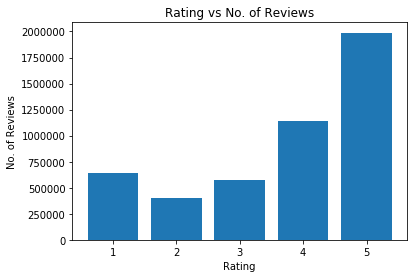

In [47]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_rating(file_path):
    rating = [0,0,0,0,0,0]
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        rating[j["stars"]]+=1
    file.close()
    return rating

ratings = reviews_vs_rating(os.path.join("..","data","review.json"))
plotter.bar([1,2,3,4,5],ratings[1:])
plotter.xlabel('Rating')
plotter.ylabel('No. of Reviews')
plotter.title('Rating vs No. of Reviews')
plotter.show()

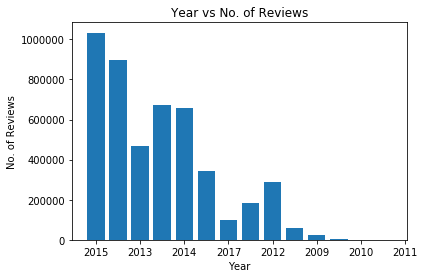

In [23]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_date(file_path):
    dates = dict()
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        d = j["date"][0:4]
        if d in dates:
            dates[d] += 1
        else:
            dates[d] = 1
    file.close()
    return dates

dates = reviews_vs_date(os.path.join("..","data","review.json"))

ax = plotter.subplot(111)
ax.bar(range(len(dates.keys())),list(dates.values()))
ax.set_xticklabels(dates.keys())
plotter.xlabel('Year')
plotter.ylabel('No. of Reviews')
plotter.title('Year vs No. of Reviews')
plotter.show()

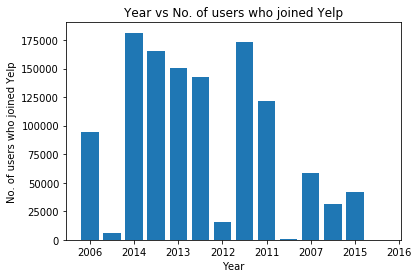

In [20]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_date(file_path):
    dates = dict()
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        d = j["yelping_since"][0:4]
        if d in dates:
            dates[d] += 1
        else:
            dates[d] = 1
    file.close()
    return dates

dates = reviews_vs_date(os.path.join("..","data","user.json"))

ax = plotter.subplot(111)
ax.bar(range(len(dates.keys())),list(dates.values()))
ax.set_xticklabels(dates.keys())
plotter.xlabel('Year')
plotter.ylabel('No. of users who joined Yelp')
plotter.title('Year vs No. of users who joined Yelp')
plotter.show()

{'7KPBkxAOEtb3QeIL9PEErg': [7, 13, 16, 16, 17, 24, 20], 'kREVIrSBbtqBhIYkTccQUg': [1, 0, 1, 2, 0, 2, 1], 'tJRDll5yqpZwehenzE2cSg': [2, 0, 0, 1, 0, 1, 0], 'nhZ1HGWD8lMErdn3FuWuTQ': [8, 8, 3, 5, 5, 10, 6]}


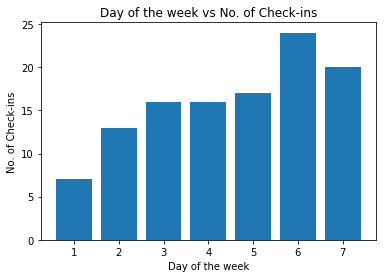

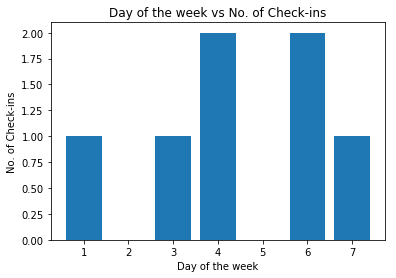

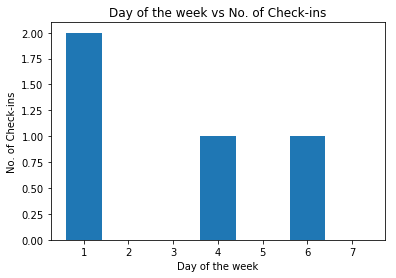

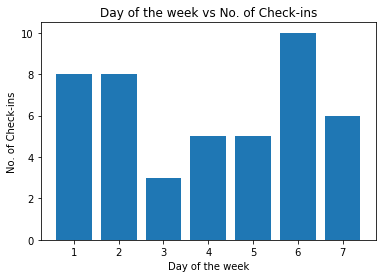

In [15]:
import json
import os
import matplotlib.pyplot as plotter

def checkin_vs_date(file_path):
    dates = dict()
    with open(file_path,"r") as file:
        for i in range(4):
            line = file.readline()
            j = json.loads(line)
            check_ins = list()
            days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
            for day in days:
                if day in j['time']:
                    total_check_in = 0
                    for time in j['time'][day].keys():
                        total_check_in += j['time'][day][time]
                    check_ins.append(total_check_in)
                else:
                    check_ins.append(0)
            dates[j['business_id']] = check_ins
            
    return dates

dates = checkin_vs_date(os.path.join("..","data","checkin.json"))
print(dates)

for business in dates.keys():
    plotter.bar([1,2,3,4,5,6,7],dates[business])
    plotter.xlabel('Day of the week')
    plotter.ylabel('No. of Check-ins')
    plotter.title('Day of the week vs No. of Check-ins')
    plotter.show()

In [1]:
import os
import pandas

checkins = pandas.read_csv(os.path.join("..","data","checkin_csv","checkin.csv"))
checkin_vals = checkins['no_of_checkins']
checkins = checkins.drop(['no_of_checkins'],axis=1)
print(checkins.values)
print(checkin_vals.values)

[[124669      5     21]
 [124669      5      1]
 [124669      5      4]
 ..., 
 [ 65124      4      0]
 [ 65124      4      1]
 [ 65124      4      8]]
[4 1 1 ..., 3 4 1]


In [5]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(checkins.values, checkin_vals.values)
reg.predict([[21589,6,13]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([ 4.31076909])

In [5]:
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(solver='sgd',hidden_layer_sizes=(2), random_state=1, max_iter=100)
ann.fit(checkins.values, checkin_vals.values)
ann.predict([[21589,6,13]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([ 4.29579982])

In [9]:
ann.predict([[2573,3,23]])

array([ 4.29579982])